In [ ]:
#https://github.com/NifTK/NiftyNet/blob/8b9f3e40b6d0f3db61fab34d3b7afca43b93723d/demos/crf_as_rnn/crf_as_rnn_inference_demo.ipynb

In [12]:
#import 
import sys
sys.path.append("../../NiftyNet/")

In [13]:
from niftynet.layer.crf import CRFAsRNNLayer

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [26]:
#ct_image = nib.load('/data-nas/brains/MICCAI_BraTS2018/interim/HGG/Brats18_TCIA06_184_1/Brats18_TCIA06_184_1_t1.nii.gz').get_data()
#logits = nib.load('/data-nas/sathiesh/niftynet_brain/outputs/brats/inference/Brats18_TCIA06_184_1_niftynet_out.nii.gz').get_data()

ct_image = nib.load('/data-nas/brains/IXI_Dataset/interim_copy_test/IXI311/IXI311_t1.nii.gz').get_data()
logits = nib.load('/data-nas/sathiesh/niftynet_brain/outputs/ixi/inference/IXI311_niftynet_out.nii.gz').get_data()



print('MR image shape: {}'.format(ct_image.shape))
print('Predicted logits shape: {}'.format(logits.shape))

MR image shape: (256, 256, 150)
Predicted logits shape: (256, 256, 150, 1, 1)


In [43]:
slice_idx = 50
ct_slice = np.transpose(ct_image[::-1, ::-1, slice_idx])
ct_logits = np.transpose(logits[::-1, ::-1, slice_idx, 0, :], axes=(0,1, 2))
#ct_logits = np.transpose(logits[::-1, ::-1, slice_idx, 0, 0], axes=(1, 0))

print('CT slice shape: {}'.format(ct_slice.shape))
print('Predicted logits shape: {}'.format(ct_logits.shape))

CT slice shape: (256, 256)
Predicted logits shape: (256, 256, 1)


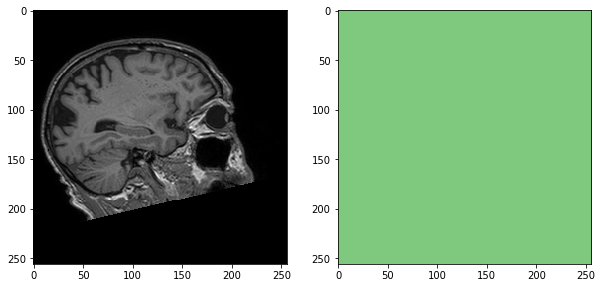

In [41]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(ct_slice, cmap='gray')
axes[1].imshow(np.argmax(ct_logits, -1), cmap='Accent')

In [21]:
# make a tensor with batch size 1 and channel 9
tf_logits = tf.constant(ct_logits, dtype=tf.float32)
tf_logits = tf.expand_dims(tf_logits, axis=0)
print(tf_logits)

# make a tensor of the CT intensity
tf_features = tf.constant(ct_slice, dtype=tf.float32)
tf_features = tf.expand_dims(tf_features, axis=0)
tf_features = tf.expand_dims(tf_features, axis=-1)
print(tf_features)

Tensor("ExpandDims:0", shape=(1, 240, 240, 1), dtype=float32)
Tensor("ExpandDims_2:0", shape=(1, 240, 240, 1), dtype=float32)


In [22]:
crf_layer = CRFAsRNNLayer(alpha=50., beta=3., gamma=3., T=5,
                          w_init=[1.0 * np.ones(1), 3.0 * np.ones(1)])
smoothed_logits = crf_layer(tf_features, tf_logits)
smoothed_label = tf.cast(tf.argmax(smoothed_logits, -1), tf.int32)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_label = sess.run(smoothed_label)

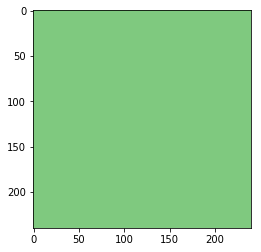

In [23]:
plt.imshow(output_label[0,...], cmap='Accent')